#**Importing Libraries**

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

#**Load dataset**

In [2]:
df = pd.read_csv("DataCoSupplyChainDataset.csv", encoding="latin1")

#**Data preprocessing**
Dropping the features which are not important or duplicated

In [3]:
drop_cols = ['Type', 'Sales per customer', 'Delivery Status', 'Late_delivery_risk', 'Category Id', 'Category Name',
             'Customer City', 'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id', 'Customer Lname',
             'Customer Password', 'Customer Segment', 'Customer State', 'Customer Street', 'Customer Zipcode',
             'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market', 'Order City', 'Order Country',
             'Order Customer Id', 'Order Id', 'Order Item Cardprod Id', 'Order Item Discount Rate', 'Order Item Id',
             'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status', 'Order Zipcode',
             'Product Category Id', 'Product Description', 'Product Image', 'Product Name', 'Product Price',
             'Product Status', 'shipping date (DateOrders)', 'Shipping Mode']
df.drop(columns=drop_cols, inplace=True)

**Aggregate sales and quantity per product**

Calculated total sales and average demand and standard deviation for each product

In [4]:
product_sales = df.groupby("Product Card Id")["Sales"].sum().reset_index()
product_demand = df.groupby("Product Card Id")["Order Item Quantity"].agg(["mean", "std"]).reset_index()

**Merge and Classify products**

Merged the aggreagated data for ABC and XYZ classification

In [5]:
data = pd.merge(product_sales, product_demand, on="Product Card Id")
data.rename(columns={"Sales": "Total Sales"}, inplace=True)
data.sort_values(by="Total Sales", ascending=False, inplace=True)
data["Cumulative Sales"] = data["Total Sales"].cumsum()
total_sales = data["Total Sales"].sum()
data["Sales Percentage"] = (data["Cumulative Sales"] / total_sales) * 100

data["ABC Category"] = data["Sales Percentage"].apply(lambda x: "A" if x <= 80 else "B" if x <= 95 else "C")
data["CV"] = data["std"] / data["mean"]
data["XYZ Category"] = data["CV"].apply(lambda x: "X" if x < 0.5 else "Y" if x <= 1 else "Z")
data["ABC-XYZ"] = data["ABC Category"] + data["XYZ Category"]

df = df.merge(data[["Product Card Id", "ABC-XYZ"]], on="Product Card Id", how="left")
df["Order Date"] = pd.to_datetime(df["order date (DateOrders)"]).dt.strftime("%m-%Y")
df.drop(columns=["order date (DateOrders)"], inplace=True)

target = "Order Item Quantity"
df.dropna(subset=[target], inplace=True)

**Encoding Categorical Variables**

Since we are using Regression, we need to encode categorical variable as it needs numerical data

In [7]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
categorical_encoded = encoder.fit_transform(df[["ABC-XYZ"]])
categorical_encoded = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out())

df = df.join(categorical_encoded).drop(columns=["ABC-XYZ"])

**Feature scaling**

Normalizing using z-score to ensure fair comparison between features

In [45]:
scaler = StandardScaler()
feature_cols = [col for col in df.columns if col not in ["Order Item Quantity", "Order Date", "Product Card Id"]]
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# **Forecasting demand**

In [21]:
forecast_results = []
monthly_demand = df.groupby(["Order Date", "Product Card Id"])["Order Item Quantity"].sum().reset_index()
sub_df = monthly_demand.merge(df, on=["Product Card Id", "Order Date"], how="inner")
sub_df.columns = sub_df.columns.str.strip()

,Order Date,Product Card Id,Order Item Quantity_x,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Order Item Discount,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity_y,Sales,Order Item Total,ABC-XYZ_AX,ABC-XYZ_BX,ABC-XYZ_BY,ABC-XYZ_CX,ABC-XYZ_CY
0,01-2015,37,11,0.942935,-0.626384,-0.474410,-0.083078,-0.772016,-0.755574,4,-0.431720,-0.461474,-1.731818,-0.411308,-0.059944,3.249228,-0.124446
1,01-2015,37,11,-0.906907,-1.350064,-0.887571,-0.687473,-0.772016,-1.764781,3,-0.698699,-0.647150,-1.731818,-0.411308,-0.059944,3.249228,-0.124446
2,01-2015,37,11,0.942935,-0.626384,0.146745,0.178484,-0.772016,0.403941,4,-0.431720,-0.508630,-1.731818,-0.411308,-0.059944,3.249228,-0.124446
3,01-2015,44,26,0.326321,0.820976,-0.244692,0.328415,-0.582916,-0.326124,3,-0.126439,-0.198749,-1.731818,-0.411308,16.682139,-0.307765,-0.124446
4,01-2015,44,26,0.942935,-0.626384,0.451087,0.188292,-0.582916,0.403941,4,0.331294,0.331670,-1.731818,-0.411308,16.682139,-0.307765,-0.124446


#**Training, Testing and Evaluating the Model**

This script performs demand forecasting based on ABC-XYZ classification by training separate models for each category. It filters the dataset for each classification, selects relevant features, and splits the data into training and testing sets. Two models, Ridge Regression and Random Forest Regressor, are trained and evaluated using cross-validation and multiple error metrics (MAE, RMSE, MAPE, and R-Squared Score). The actual and predicted demand values are stored for each category, enabling comparative analysis. Finally, all results are combined into a single dataframe for further analysis and visualization.

In [40]:
for category in sub_df.columns[sub_df.columns.str.contains("ABC-XYZ_")]:
    print(category)
    filtered_df = sub_df[sub_df[category] > 0]

    if "Order Item Quantity_x" not in filtered_df.columns:
        raise KeyError("Column 'Order Item Quantity' not found in filtered_df")

    X = filtered_df[feature_cols]
    y = filtered_df["Order Item Quantity_x"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

    model = Ridge(alpha=5.0)  # Regularized linear model
    model_rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)  # Tuned Random Forest  # Regularized linear model
    model.fit(X_train, y_train)
    model_rf.fit(X_train, y_train)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"Cross-Validation Score (Ridge): {np.mean(scores):.2f}")
    y_pred = model.predict(X_test)
    scores_rf = cross_val_score(model_rf, X_train, y_train, cv=5)
    print(f"Cross-Validation Score (RF): {np.mean(scores_rf):.2f}")
    y_pred_rf = model_rf.predict(X_test)

    print(f"Performance for {category}:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred):.2f}")
    print(f"R^2 Score: {r2_score(y_test, y_pred):.2f}\n")

    print(f"Performance for {category} (Random Forest):")
    print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")
    print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred_rf):.2f}")
    print(f"R^2 Score: {r2_score(y_test, y_pred_rf):.2f}\n")

    results_df = filtered_df[["Order Date"]].iloc[:len(y_test)].copy()
    results_df["Actual Demand"] = y_test.values
    results_df["Predicted Demand"] = y_pred
    results_df["Category"] = category
    forecast_results.append(results_df)

forecast_df = pd.concat(forecast_results)

ABC-XYZ_AX
Cross-Validation Score (Ridge): 0.63
Cross-Validation Score (RF): 0.97
Performance for ABC-XYZ_AX:
MAE: 173.69
RMSE: 219.03
MAPE: 0.36
R^2 Score: 0.63

Performance for ABC-XYZ_AX (Random Forest):
MAE: 38.27
RMSE: 57.14
MAPE: 0.09
R^2 Score: 0.98

ABC-XYZ_BX
Cross-Validation Score (Ridge): 0.07
Cross-Validation Score (RF): 0.83
Performance for ABC-XYZ_BX:
MAE: 248.40
RMSE: 388.37
MAPE: 4.30
R^2 Score: 0.07

Performance for ABC-XYZ_BX (Random Forest):
MAE: 84.58
RMSE: 190.06
MAPE: 0.76
R^2 Score: 0.78

ABC-XYZ_BY
Cross-Validation Score (Ridge): 0.04
Cross-Validation Score (RF): -0.06
Performance for ABC-XYZ_BY:
MAE: 5.38
RMSE: 6.41
MAPE: 0.34
R^2 Score: -0.07

Performance for ABC-XYZ_BY (Random Forest):
MAE: 5.83
RMSE: 7.09
MAPE: 0.38
R^2 Score: -0.30

ABC-XYZ_CX
Cross-Validation Score (Ridge): 0.08
Cross-Validation Score (RF): 0.90
Performance for ABC-XYZ_CX:
MAE: 57.88
RMSE: 83.10
MAPE: 2.35
R^2 Score: 0.12

Performance for ABC-XYZ_CX (Random Forest):
MAE: 12.56
RMSE: 25.72


Based on the Results, we can see that Random Forest Regressor provides better R-Squared Score. Based on MAPE as well, the variance is under control for the products that are revenue drivers. As for other products, we can try using statistical models to get better accuracy an derror measure values.

#**Visualizing results for evaluation**

 The **Residual Plot** helps to check if the residuals are random or contains some pattern. The red LOWESS (Locally Weighted Scatterplot Smoothing) line suggests a slight trend, which could indicate non-linearity. Also, the spread of residuals appears to increase at higher Actual Demand values, suggesting that the model may struggle to predict higher demand accurately.

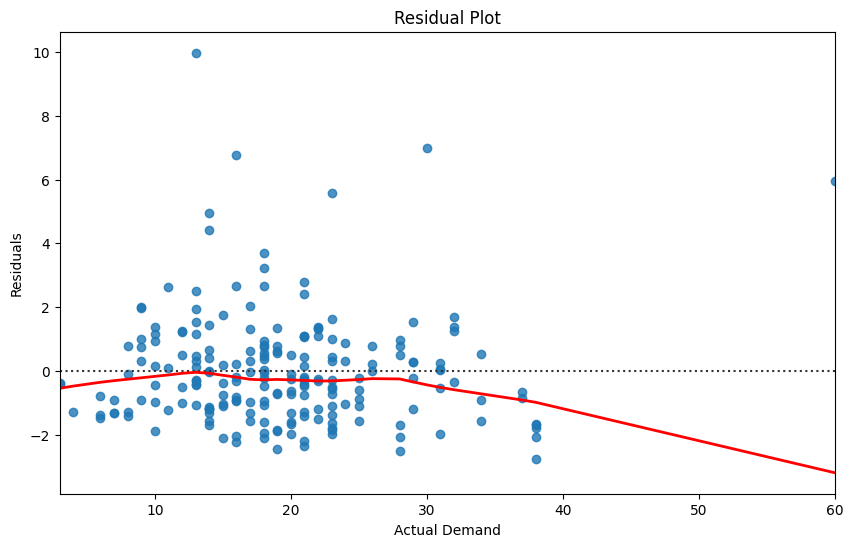

In [41]:
plt.figure(figsize=(10,6))
sns.residplot(x=y_test, y=y_pred, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.xlabel("Actual Demand")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

The **Error Distribution Plot** helps to visualizes the distribution of prediction errors. The distribution looks centered with a small right skewed tail suggesting that model can overestimates the demand.

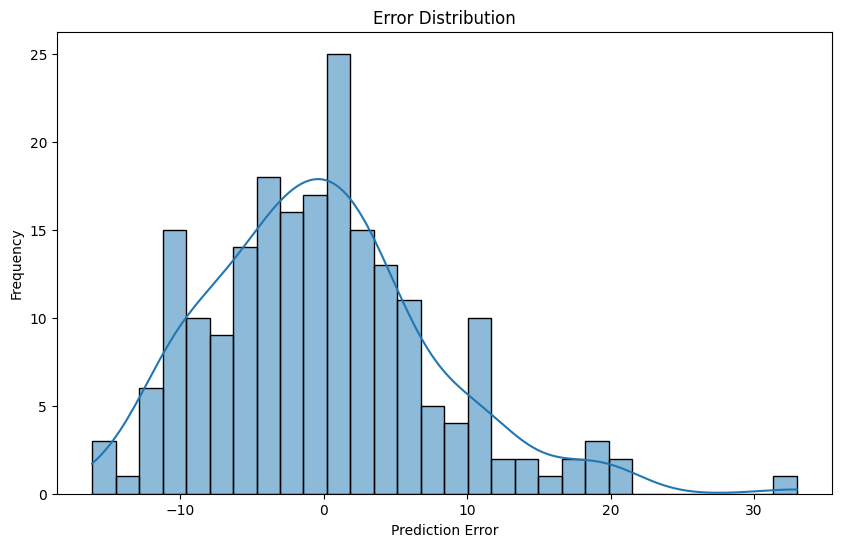

In [42]:
errors = y_test - y_pred
plt.figure(figsize=(10,6))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.show()

#**Future Scope**

The current demand forecasting model provides a strong foundation, but there are several areas for future improvement. First, incorporating additional external factors such as seasonal trends, economic indicators, or competitor pricing could enhance predictive accuracy. Second, experimenting with advanced machine learning models like XGBoost or deep learning techniques could improve performance, especially in handling non-linear relationships. Third, refining the feature selection process using automated techniques like Recursive Feature Elimination (RFE) may help eliminate redundant variables and improve model efficiency. Lastly, implementing real-time forecasting with dynamic updates based on incoming data could make the model more responsive to changing demand patterns.